In [1]:
import tensorflow as tf
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import pandas as pd
import numpy as np

In [2]:
def load_dataset(file_path, text_column, label_column):
    df = pd.read_csv(file_path)
    texts = df[text_column].values
    labels = df[label_column].values
    return texts, labels

In [3]:
def split_dataset(texts, labels, test_size=0.2, random_state=42):
    return train_test_split(texts, labels, test_size=test_size, random_state=random_state)

In [4]:
def tokenize_data(tokenizer, texts, max_length=128):
    encodings = tokenizer(list(texts), truncation=True, padding=True, max_length=max_length, return_tensors='tf')
    return encodings['input_ids']

In [5]:
def build_model(pretrained_model_name, num_labels):
    model = TFAutoModelForSequenceClassification.from_pretrained(pretrained_model_name, num_labels=num_labels)
    return model

In [6]:
def compile_model(model, learning_rate=5e-5):
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )
    return model

In [7]:
def train_model(model, train_input_ids, train_labels, val_input_ids, val_labels, epochs=5, batch_size=16):
    history = model.fit(
        train_input_ids, 
        train_labels, 
        validation_data=(val_input_ids, val_labels),
        epochs=epochs,
        batch_size=batch_size
    )
    return history

In [8]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

In [9]:
def evaluate_on_train(model, train_input_ids, train_labels, class_names):
    y_pred_train = np.argmax(model.predict(train_input_ids)[0], axis=1)
    print("Training Classification Report:\n", classification_report(train_labels, y_pred_train))
    
    conf_matrix_train = confusion_matrix(train_labels, y_pred_train)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix_train, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Training Confusion Matrix')
    plt.show()

    accuracy_train = accuracy_score(train_labels, y_pred_train)
    print(f"Training Accuracy: {accuracy_train * 100:.2f}%")
    return y_pred_train

In [10]:
def evaluate_model(model, input_ids, true_labels, class_names):
    y_pred = np.argmax(model.predict(input_ids)[0], axis=1)
    print("Classification Report:\n", classification_report(true_labels, y_pred))
    
    conf_matrix = confusion_matrix(true_labels, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    accuracy = accuracy_score(true_labels, y_pred)
    print(f"Accuracy: {accuracy * 100:.2f}%")
    return y_pred

In [11]:
def save_predictions(texts, true_labels, predicted_labels, output_file):
    predictions_df = pd.DataFrame({
        'Text': texts,
        'True Label': true_labels,
        'Predicted Label': predicted_labels
    })
    predictions_df.to_csv(output_file, index=False)
    print(f"Predictions saved to '{output_file}'.")

In [12]:
def predict_on_new_data(model, tokenizer, new_test_file, text_column, output_file, max_length=128):
    new_test_data = pd.read_csv(new_test_file)
    if text_column not in new_test_data.columns:
        raise ValueError(f"Column '{text_column}' not found in the new test dataset.")
    new_test_texts = new_test_data[text_column].values
    new_test_encodings = tokenize_data(tokenizer, new_test_texts, max_length=max_length)
    new_predictions = np.argmax(model.predict(new_test_encodings)[0], axis=1)
    new_test_data['Class (Predicted Label)'] = new_predictions
    new_test_data.to_csv(output_file, index=False)
    print(f"New test predictions saved to '{output_file}'.")

In [12]:
def predict_on_new_data(model, tokenizer, new_test_file, text_column, output_file, max_length=128):
    new_test_data = pd.read_csv(new_test_file)
    
    if text_column not in new_test_data.columns:
        raise ValueError(f"Column '{text_column}' not found in the new test dataset.")
    
    new_test_texts = new_test_data[text_column].values
    
    # Tokenizing the new test data
    new_test_encodings = tokenize_data(tokenizer, new_test_texts, max_length=max_length)
    
    # Model prediction (logits) for multi-class classification
    logits = model.predict(new_test_encodings)[0]  # Get logits (output of the last layer)
    
    # Apply argmax to get the predicted class (0, 1, or 2) for each input
    new_predictions = np.argmax(logits, axis=1)  # Get class with the highest logit
    
    # Add the predicted class labels to the dataframe
    new_test_data['Class (Predicted Label)'] = new_predictions
    
    # Save the predictions to a new CSV file
    new_test_data.to_csv(output_file, index=False)
    
    print(f"New test predictions saved to '{output_file}'.")

In [13]:
def predict_on_new_data(saved_model_dir, new_test_file, text_column, output_file, max_length=128):
    model = TFAutoModelForSequenceClassification.from_pretrained(saved_model_dir)
    tokenizer = AutoTokenizer.from_pretrained(saved_model_dir)
    
    new_test_data = pd.read_csv(new_test_file)
    if text_column not in new_test_data.columns:
        raise ValueError(f"Column '{text_column}' not found in the new test dataset.")
    
    new_test_texts = new_test_data[text_column].values
    new_test_encodings = tokenize_data(tokenizer, new_test_texts, max_length=max_length)
    
    logits = model.predict(new_test_encodings)[0]  # Get logits for each class
    
    new_predictions = np.argmax(logits, axis=1)  # Choose the class with the highest logit
    
    new_test_data['Class (Predicted Label)'] = new_predictions
    
    new_test_data.to_csv(output_file, index=False)
    print(f"New test predictions saved to '{output_file}'.")

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model saved to 'D:\epita class notes\semester - 3\action learnign\project repository\Hate_speech_detection_using_data_augmentation\Hate_speech_detection_using_data_augmentation\nlp_models\fine_tuned_bert_with_augmented_dataset.h5'
Epoch 1/3
38/38 [==============================] - 147s 3s/step - loss: 0.6603 - accuracy: 0.7525 - val_loss: 0.4637 - val_accuracy: 0.8733
Epoch 2/3
38/38 [==============================] - 130s 3s/step - loss: 0.3868 - accuracy: 0.8825 - val_loss: 0.3618 - val_accuracy: 0.8733
Epoch 3/3
38/38 [==============================] - 135s 4s/step - loss: 0.2262 - accuracy: 0.9300 - val_loss: 0.2855 - val_accuracy: 0.9033


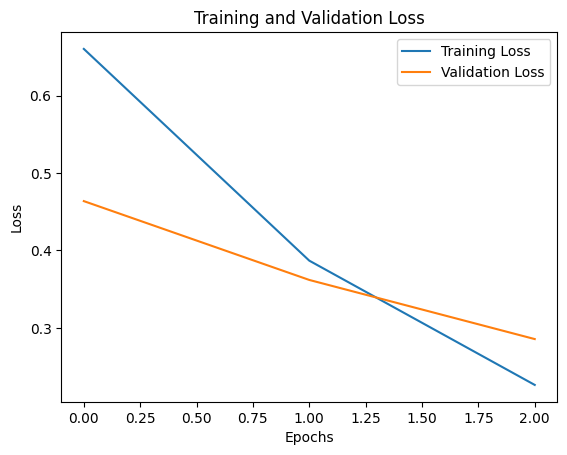

38/38 [==============================] - 40s 972ms/step
Training Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.52      0.69        61
           1       0.97      0.99      0.98       920
           2       0.96      0.97      0.96       219

    accuracy                           0.97      1200
   macro avg       0.98      0.83      0.88      1200
weighted avg       0.97      0.97      0.96      1200



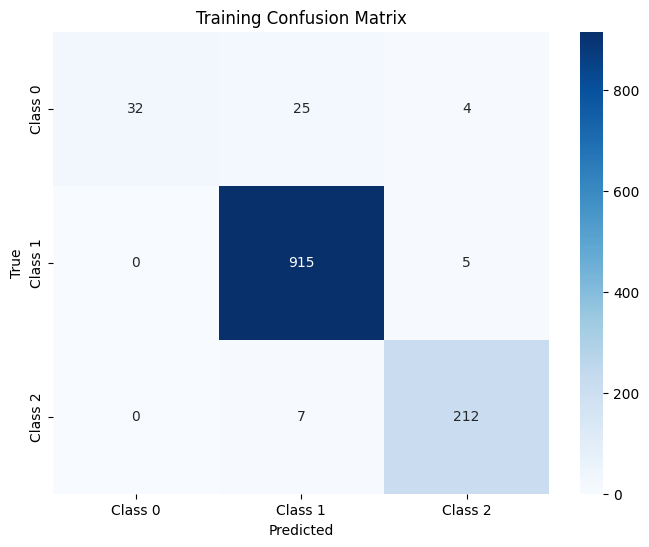

Training Accuracy: 96.58%
10/10 [==============================] - 11s 811ms/step
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.37      0.54        19
           1       0.91      0.97      0.94       231
           2       0.83      0.78      0.80        50

    accuracy                           0.90       300
   macro avg       0.91      0.71      0.76       300
weighted avg       0.91      0.90      0.89       300



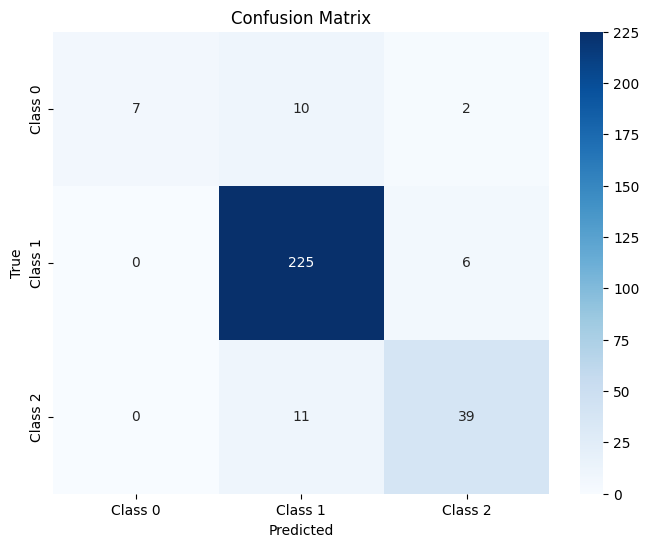

Accuracy: 90.33%


In [17]:
dataset_file = r"D:\epita class notes\semester - 3\action learnign\project repository\Hate_speech_detection_using_data_augmentation\Hate_speech_detection_using_data_augmentation\data\augmented_dataset\augmented_data.csv"
output_predictions = "test_predictions.csv"

text_column = "corrected_tweet"
label_column = "class"

texts, labels = load_dataset(dataset_file, text_column, label_column)
X_train, X_test, y_train, y_test = split_dataset(texts, labels)

tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
train_input_ids = tokenize_data(tokenizer, X_train)
test_input_ids = tokenize_data(tokenizer, X_test)

num_labels = len(set(labels))
model = build_model('bert-base-uncased', num_labels)
model = compile_model(model)

model_save_dir = r"D:\epita class notes\semester - 3\action learnign\project repository\Hate_speech_detection_using_data_augmentation\Hate_speech_detection_using_data_augmentation\nlp_models\fine_tuned_bert_with_augmented_dataset.h5"
model.save_pretrained(model_save_dir)
tokenizer.save_pretrained(model_save_dir)
print(f"Model saved to '{model_save_dir}'")

history = train_model(model, train_input_ids, y_train, test_input_ids, y_test)
plot_loss(history)

class_names = ["Class 0", "Class 1", "Class 2"]
train_predictions = evaluate_on_train(model, train_input_ids, y_train, class_names)
y_pred = evaluate_model(model, test_input_ids, y_test, class_names)
#save_predictions(X_test, y_test, y_pred, output_predictions)



In [15]:
test_file = r"D:\epita class notes\semester - 3\action learnign\project repository\Hate_speech_detection_using_data_augmentation\Hate_speech_detection_using_data_augmentation\data\cleaned_dataset\labeled_data_cleaned_test.csv"
new_test_predictions = r"D:\epita class notes\semester - 3\action learnign\project repository\Hate_speech_detection_using_data_augmentation\Hate_speech_detection_using_data_augmentation\data\cleaned_dataset\predictions_test.csv"
predict_on_new_data(model_save_dir, test_file, text_column, new_test_predictions)


Some layers from the model checkpoint at D:\epita class notes\semester - 3\action learnign\project repository\Hate_speech_detection_using_data_augmentation\Hate_speech_detection_using_data_augmentation\nlp_models\fine_tuned_bert_with_normal_dataset.h5 were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at D:\epita class notes\semester - 3\action learnign\project repository\Hate_s

32/32 [==============================] - 25s 682ms/step
New test predictions saved to 'D:\epita class notes\semester - 3\action learnign\project repository\Hate_speech_detection_using_data_augmentation\Hate_speech_detection_using_data_augmentation\data\cleaned_dataset\predictions_test.csv'.
